In [1]:
import os
os.environ['PYSPARK_PYTHON'] = '/home/luban/anaconda3/envs/python36/bin/python'
import findspark
findspark.init()

from pyspark import *
from pyspark.sql import *

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

app_name = 'xuyunqing_juypter'
conf = (SparkConf().setAppName(app_name)
        .set('spark.master', 'yarn')
        .set('spark.submit.deployMode', 'client')
        .set('spark.driver.memory',                  '20g')
        .set('spark.executor.memory',                '8g')
        .set('spark.dynamicAllocation.minExecutors', '2')
        .set('spark.dynamicAllocation.maxExecutors', '200')
        .set('spark.yarn.queue',                     'root.pricing_dape_core_service_prod')
        .set('spark.ui.port','8060')
        .set('spark.executor.memoryOverhead','4096')
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
        .set('spark.driver.allowMultipleContexts', 'True')
        .set('spark.yarn.dist.archives','hdfs://DClusterNmg4/user/bigdata_driver_ecosys_test/ly/python_env/python3.6.2.tgz#python3.6.2')
        .set('spark.pyspark.driver.python',          '/home/luban/anaconda3/envs/python36/bin/python')
        .set('spark.pyspark.python', './python3.6.2/bin/python')
        .set("spark.yarn.appMasterEnv.PYSPARK_PYTHON", './python3.6.2/bin/python')
        )
spark = SparkSession.builder.config(conf = conf).enableHiveSupport().getOrCreate()
sc = spark.sparkContext

from pyspark.sql.functions import col,udf,date_sub,explode,split,date_add
from pyspark.sql.types import StringType,DoubleType,IntegerType
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('expand_frame_repr',False)
import matplotlib.pyplot as plt

from pyspark.sql import functions as F
hc = HiveContext(sc)

In [2]:
covid_sql = '''
    select  city_id,
            concat_ws('-',year,month,day) as dt,
            covid_status
    from	prod_smt_dw.dm_sunrise_post_city_covid_status
    where   concat_ws('-',year,month,day) between '2022-03-01' and '2022-09-01'
    '''

def filter_covid(namy):
    # 过滤疫情期间的数据
    covid_df = hc.sql(covid_sql).toPandas()
    namy_nor = pd.merge(namy,covid_df,on = ['city_id','dt'],how = 'left').query('covid_status == 0 | covid_status == 1 | covid_status == 5')
    return namy_nor

In [3]:
df1 = spark.sql('''
select
    city_id
    ,dt
    ,case when group_name in ('rgroup_kt_blank','rgroup_kt_blank2','rgroup_default_blank') then 'blank'
    else 'exp' end as group_type
    ,sum(xfk_pid_count) as pid_cnt
    ,sum(xfk_call_cnt) as call_cnt
    ,sum(xfk_succ_cnt) as success_cnt
    ,sum(xfk_gmv) as gmv
    ,sum(xfk_subsidy_hufan)/sum(xfk_gmv) as subsidy_hufan_rate
    ,sum(xfk_subsidy_c)/sum(xfk_gmv) as subsidy_c_rate
from
    smt_dw.drs_kt_hufan_group_gmv_funnel
where
    dt between '2022-03-01' and '2022-09-01'
group by
    city_id
    ,dt
    ,case when group_name in ('rgroup_kt_blank','rgroup_kt_blank2','rgroup_default_blank') then 'blank'
    else 'exp' end
''').toPandas()
df2 = filter_covid(df1)
df2

,city_id,dt,group_type,pid_cnt,call_cnt,success_cnt,gmv,subsidy_hufan_rate,subsidy_c_rate,covid_status
1,201,2022-04-18,blank,280.0,25.0,0.0,0.00,NaN,NaN,0.0
2,327,2022-04-18,blank,12.0,15.0,1.0,5.00,0.000000,0.000000,0.0
6,335,2022-04-18,exp,2913.0,2972.0,2239.0,21761.49,0.016726,0.037123,0.0
7,49,2022-04-18,blank,2537.0,1653.0,1351.0,21168.33,0.000051,0.055105,0.0
8,356,2022-04-18,blank,12.0,15.0,0.0,0.00,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
120879,229,2022-03-21,blank,972.0,1264.0,453.0,5406.59,0.005301,0.062320,0.0
120880,71,2022-03-21,exp,4307.0,3300.0,2760.0,39317.55,0.030179,0.102555,5.0
120881,72,2022-03-21,blank,595.0,629.0,485.0,5475.44,0.000000,0.171690,0.0
120882,75,2022-03-21,blank,210.0,65.0,4.0,40.88,0.000000,0.024462,0.0


In [4]:
df3 = df2.dropna(axis=0)
df4 = df3.sort_values(by=['city_id', 'dt', 'group_type'])
df4['pp_call_cnt'] = df4['call_cnt']/df4['pid_cnt']
df4['cr'] = df4['success_cnt']/df4['call_cnt']
df5 = df4.groupby(['city_id', 'dt']).count().reset_index()[['city_id', 'dt', 'group_type']].rename(columns={'group_type':'cnt'})
df6 = pd.merge(df4, df5, on=['city_id', 'dt'])
df7 = df6[df6['cnt'] == 2]
df7

,city_id,dt,group_type,pid_cnt,call_cnt,success_cnt,gmv,subsidy_hufan_rate,subsidy_c_rate,covid_status,pp_call_cnt,cr,cnt
0,1,2022-03-01,blank,84602.0,68801.0,57310.0,1830839.88,0.000126,0.044296,5.0,0.813231,0.832982,2
1,1,2022-03-01,exp,762367.0,624287.0,518873.0,16731265.23,0.015598,0.058385,5.0,0.818880,0.831145,2
2,1,2022-03-02,blank,84353.0,67965.0,57602.0,1837523.17,0.000095,0.049243,5.0,0.805721,0.847524,2
3,1,2022-03-02,exp,759027.0,617157.0,522121.0,16877434.46,0.018335,0.065112,5.0,0.813090,0.846010,2
4,1,2022-03-03,blank,85101.0,68362.0,57849.0,1840101.27,0.000177,0.051010,5.0,0.803304,0.846216,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92349,372,2022-08-30,exp,2263.0,2155.0,1817.0,20658.27,0.005356,0.039825,0.0,0.952276,0.843155,2
92350,372,2022-08-31,blank,235.0,214.0,177.0,2055.72,0.000978,0.024926,0.0,0.910638,0.827103,2
92351,372,2022-08-31,exp,2143.0,2024.0,1692.0,20433.73,0.004295,0.040028,0.0,0.944470,0.835968,2
92352,372,2022-09-01,blank,250.0,262.0,208.0,2452.59,0.000269,0.023600,0.0,1.048000,0.793893,2


In [5]:
df8 = df7[df7['group_type'] == 'blank']
df9 = df7[df7['group_type'] == 'exp']
df9['pp_call_cnt_growth_rate'] = df9['pp_call_cnt'].values/df8['pp_call_cnt'].values - 1
df9['delta_pp_call_cnt'] = df9['pp_call_cnt'].values - df8['pp_call_cnt'].values
df9['delta_cr'] = df9['cr'].values - df8['cr'].values
df9['delta_subsidy_hufan_rate'] = df9['subsidy_hufan_rate'].values - df8['subsidy_hufan_rate'].values
df9['delta_subsidy_c_rate'] = df9['subsidy_c_rate'].values - df8['subsidy_c_rate'].values
df10 = df9.drop(columns=['group_type', 'covid_status', 'cnt'])
df10

,city_id,dt,pid_cnt,call_cnt,success_cnt,gmv,subsidy_hufan_rate,subsidy_c_rate,pp_call_cnt,cr,pp_call_cnt_growth_rate,delta_pp_call_cnt,delta_cr,delta_subsidy_hufan_rate,delta_subsidy_c_rate
1,1,2022-03-01,762367.0,624287.0,518873.0,16731265.23,0.015598,0.058385,0.818880,0.831145,0.006946,0.005649,-0.001837,0.015472,0.014090
3,1,2022-03-02,759027.0,617157.0,522121.0,16877434.46,0.018335,0.065112,0.813090,0.846010,0.009145,0.007368,-0.001514,0.018240,0.015869
5,1,2022-03-03,765904.0,625259.0,529957.0,17303066.15,0.026590,0.074155,0.816367,0.847580,0.016262,0.013063,0.001364,0.026414,0.023144
7,1,2022-03-04,883685.0,728476.0,555027.0,18032554.37,0.034222,0.070578,0.824362,0.761902,0.015309,0.012430,0.000153,0.034036,0.030660
9,1,2022-03-05,702470.0,668590.0,568856.0,17960766.11,0.082015,0.134772,0.951770,0.850829,0.020577,0.019190,0.006036,0.037779,0.029321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92345,372,2022-08-28,2971.0,3231.0,2220.0,24064.47,0.006891,0.037729,1.087513,0.687094,0.055631,0.057311,-0.039291,-0.000174,0.011201
92347,372,2022-08-29,2934.0,3075.0,2366.0,24684.34,0.007708,0.039367,1.048057,0.769431,-0.149129,-0.183689,0.058091,-0.003615,0.001630
92349,372,2022-08-30,2263.0,2155.0,1817.0,20658.27,0.005356,0.039825,0.952276,0.843155,-0.035721,-0.035276,-0.018189,0.004620,-0.000661
92351,372,2022-08-31,2143.0,2024.0,1692.0,20433.73,0.004295,0.040028,0.944470,0.835968,0.037152,0.033832,0.008866,0.003318,0.015102


In [6]:
df11 = spark.sql('''
select
    city_id
    ,dt
    ,sum(total_tsh) as tsh
from
    mp_data.dm_trip_mp_sd_core_1d
where
    dt between '2022-03-01' and '2022-09-01'
    and product_id in (110100, 110400, 110800, 110103)
group by
    city_id
    ,dt
''').toPandas()
df11

,city_id,dt,tsh
0,166,2022-08-25,11848.233333
1,15,2022-07-15,208266.333333
2,55,2022-05-24,14393.933333
3,293,2022-07-15,5036.033333
4,326,2022-07-15,622.600000
...,...,...,...
67249,366,2022-04-12,0.133333
67250,25,2022-04-12,9.150000
67251,361,2022-04-12,0.000000
67252,361,2022-07-01,0.000000


In [7]:
df12 = pd.merge(df10, df11, on=['city_id', 'dt'], how='left')
df13 = df12.dropna(axis=0)
df13['tsh'] = df13['tsh'].astype('float')
df13['call_tsh_ratio'] = df13['call_cnt']/df13['tsh']
df13

,city_id,dt,pid_cnt,call_cnt,success_cnt,gmv,subsidy_hufan_rate,subsidy_c_rate,pp_call_cnt,cr,pp_call_cnt_growth_rate,delta_pp_call_cnt,delta_cr,delta_subsidy_hufan_rate,delta_subsidy_c_rate,tsh,call_tsh_ratio
0,1,2022-03-01,762367.0,624287.0,518873.0,16731265.23,0.015598,0.058385,0.818880,0.831145,0.006946,0.005649,-0.001837,0.015472,0.014090,9.553556e+05,0.653460
1,1,2022-03-02,759027.0,617157.0,522121.0,16877434.46,0.018335,0.065112,0.813090,0.846010,0.009145,0.007368,-0.001514,0.018240,0.015869,9.801922e+05,0.629629
2,1,2022-03-03,765904.0,625259.0,529957.0,17303066.15,0.026590,0.074155,0.816367,0.847580,0.016262,0.013063,0.001364,0.026414,0.023144,1.008712e+06,0.619859
3,1,2022-03-04,883685.0,728476.0,555027.0,18032554.37,0.034222,0.070578,0.824362,0.761902,0.015309,0.012430,0.000153,0.034036,0.030660,9.579955e+05,0.760417
4,1,2022-03-05,702470.0,668590.0,568856.0,17960766.11,0.082015,0.134772,0.951770,0.850829,0.020577,0.019190,0.006036,0.037779,0.029321,9.600914e+05,0.696382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45051,372,2022-08-28,2971.0,3231.0,2220.0,24064.47,0.006891,0.037729,1.087513,0.687094,0.055631,0.057311,-0.039291,-0.000174,0.011201,1.736750e+03,1.860371
45052,372,2022-08-29,2934.0,3075.0,2366.0,24684.34,0.007708,0.039367,1.048057,0.769431,-0.149129,-0.183689,0.058091,-0.003615,0.001630,1.924967e+03,1.597430
45053,372,2022-08-30,2263.0,2155.0,1817.0,20658.27,0.005356,0.039825,0.952276,0.843155,-0.035721,-0.035276,-0.018189,0.004620,-0.000661,1.845933e+03,1.167431
45054,372,2022-08-31,2143.0,2024.0,1692.0,20433.73,0.004295,0.040028,0.944470,0.835968,0.037152,0.033832,0.008866,0.003318,0.015102,1.790900e+03,1.130158


In [8]:
df14 = df13[(df13['delta_subsidy_hufan_rate'] > 0) & (df13['delta_subsidy_c_rate'] > 0)]
df14

,city_id,dt,pid_cnt,call_cnt,success_cnt,gmv,subsidy_hufan_rate,subsidy_c_rate,pp_call_cnt,cr,pp_call_cnt_growth_rate,delta_pp_call_cnt,delta_cr,delta_subsidy_hufan_rate,delta_subsidy_c_rate,tsh,call_tsh_ratio
0,1,2022-03-01,762367.0,624287.0,518873.0,16731265.23,0.015598,0.058385,0.818880,0.831145,0.006946,0.005649,-0.001837,0.015472,0.014090,9.553556e+05,0.653460
1,1,2022-03-02,759027.0,617157.0,522121.0,16877434.46,0.018335,0.065112,0.813090,0.846010,0.009145,0.007368,-0.001514,0.018240,0.015869,9.801922e+05,0.629629
2,1,2022-03-03,765904.0,625259.0,529957.0,17303066.15,0.026590,0.074155,0.816367,0.847580,0.016262,0.013063,0.001364,0.026414,0.023144,1.008712e+06,0.619859
3,1,2022-03-04,883685.0,728476.0,555027.0,18032554.37,0.034222,0.070578,0.824362,0.761902,0.015309,0.012430,0.000153,0.034036,0.030660,9.579955e+05,0.760417
4,1,2022-03-05,702470.0,668590.0,568856.0,17960766.11,0.082015,0.134772,0.951770,0.850829,0.020577,0.019190,0.006036,0.037779,0.029321,9.600914e+05,0.696382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45043,372,2022-08-20,2048.0,1863.0,1530.0,16788.06,0.003298,0.039302,0.909668,0.821256,0.059016,0.050694,0.020261,0.000085,0.003512,1.546833e+03,1.204396
45046,372,2022-08-23,1826.0,1709.0,1453.0,15849.91,0.005570,0.043662,0.935926,0.850205,-0.030818,-0.029761,0.017717,0.003126,0.011313,1.688250e+03,1.012291
45049,372,2022-08-26,2511.0,2432.0,1941.0,21210.03,0.006224,0.038860,0.968538,0.798109,-0.088621,-0.094179,0.017781,0.005245,0.001314,1.788567e+03,1.359748
45054,372,2022-08-31,2143.0,2024.0,1692.0,20433.73,0.004295,0.040028,0.944470,0.835968,0.037152,0.033832,0.008866,0.003318,0.015102,1.790900e+03,1.130158


Text(0, 0.5, 'pp_call_cnt_growth_rate')

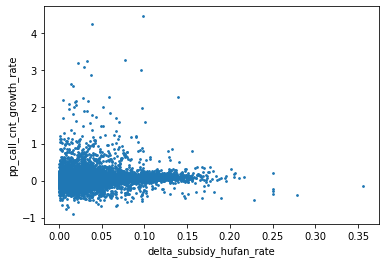

In [9]:
plt.scatter(df14['delta_subsidy_hufan_rate'], df14['pp_call_cnt_growth_rate'], s=3)
plt.xlabel('delta_subsidy_hufan_rate')
plt.ylabel('pp_call_cnt_growth_rate')

Text(0, 0.5, 'pp_call_cnt_growth_rate')

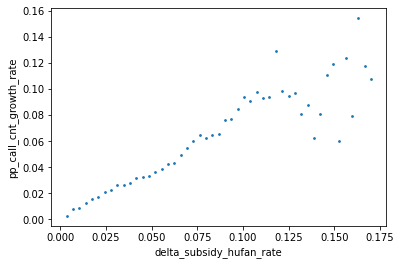

In [30]:
x = np.linspace(0, 0.17, 50)
y = np.linspace(0, 0.17, 50)
t = 0
for k, i in enumerate(x):
    y[k] = df14['pp_call_cnt_growth_rate'][(df14['delta_subsidy_hufan_rate'] >= t) & (df14['delta_subsidy_hufan_rate'] < i)].median()
    t = i
plt.scatter(x, y, s=3)
plt.xlabel('delta_subsidy_hufan_rate')
plt.ylabel('pp_call_cnt_growth_rate')

Text(0, 0.5, 'pp_call_cnt_growth_rate')

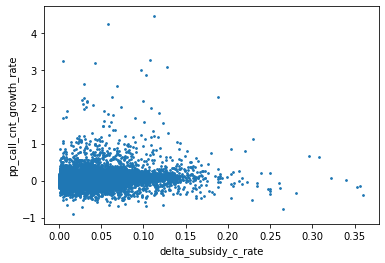

In [10]:
plt.scatter(df14['delta_subsidy_c_rate'], df14['pp_call_cnt_growth_rate'], s=3)
plt.xlabel('delta_subsidy_c_rate')
plt.ylabel('pp_call_cnt_growth_rate')

Text(0, 0.5, 'pp_call_cnt_growth_rate')

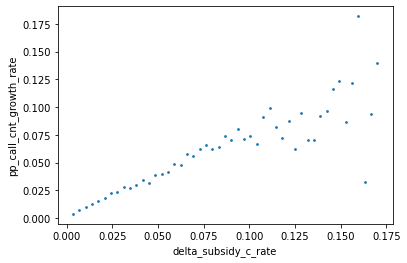

In [32]:
x = np.linspace(0, 0.17, 50)
y = np.linspace(0, 0.17, 50)
t = 0
for k, i in enumerate(x):
    y[k] = df14['pp_call_cnt_growth_rate'][(df14['delta_subsidy_c_rate'] >= t) & (df14['delta_subsidy_c_rate'] < i)].median()
    t = i
plt.scatter(x, y, s=3)
plt.xlabel('delta_subsidy_c_rate')
plt.ylabel('pp_call_cnt_growth_rate')

In [41]:
city_id = df14['city_id'].drop_duplicates().to_list()

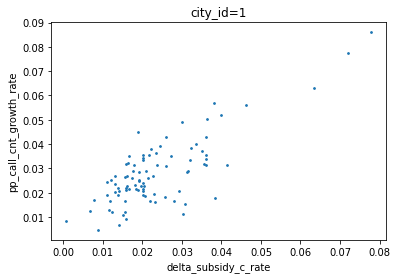

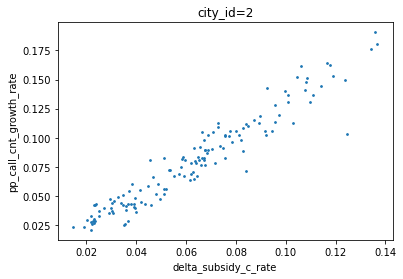

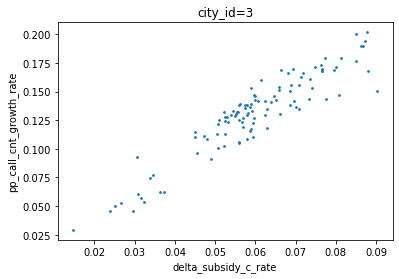

KeyboardInterrupt: 

In [66]:
for city in city_id:
    plt.figure()
    plt.scatter(df14['delta_subsidy_c_rate'][df14['city_id'] == city], df14['pp_call_cnt_growth_rate'][df14['city_id'] == city], s=3)
    plt.title(f'city_id={city}')
    plt.xlabel('delta_subsidy_c_rate')
    plt.ylabel('pp_call_cnt_growth_rate')
    plt.show()

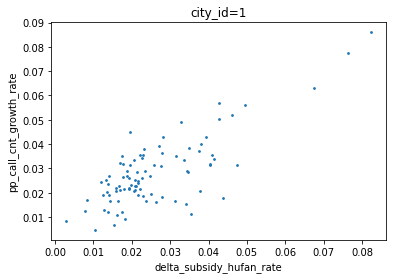

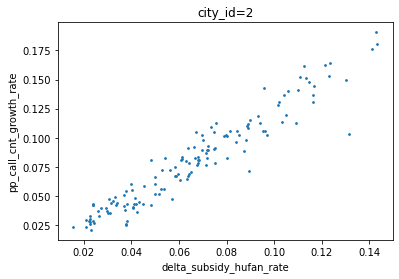

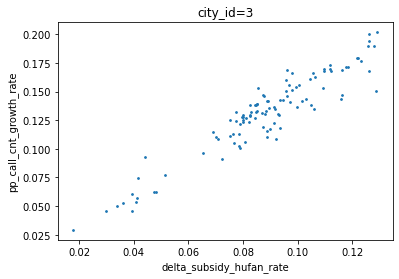

KeyboardInterrupt: 

In [65]:
for city in city_id:
    plt.figure()
    plt.scatter(df14['delta_subsidy_hufan_rate'][df14['city_id'] == city], df14['pp_call_cnt_growth_rate'][df14['city_id'] == city], s=3)
    plt.title(f'city_id={city}')
    plt.xlabel('delta_subsidy_hufan_rate')
    plt.ylabel('pp_call_cnt_growth_rate')
    plt.show()

Text(0, 0.5, 'cr')

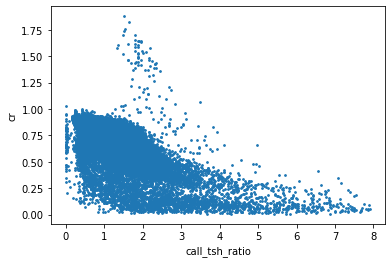

In [18]:
plt.scatter(df14['call_tsh_ratio'][df14['call_tsh_ratio'] < 8], df14['cr'][df14['call_tsh_ratio'] < 8], s=3)
plt.xlabel('call_tsh_ratio')
plt.ylabel('cr')

Text(0, 0.5, 'cr')

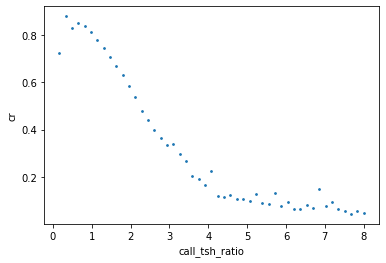

In [31]:
x = np.linspace(0, 8, 50)
y = np.linspace(0, 8, 50)
t = 0
for k, i in enumerate(x):
    y[k] = df14['cr'][(df14['call_tsh_ratio'] >= t) & (df14['call_tsh_ratio'] < i)].median()
    t = i
plt.scatter(x, y, s=3)
plt.xlabel('call_tsh_ratio')
plt.ylabel('cr')

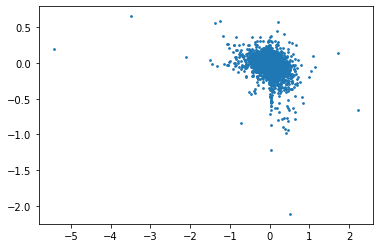

In [43]:
plt.scatter(df14['delta_pp_call_cnt'], df14['delta_cr'], s=3)

In [44]:
df14['tsh'].describe()

count    3.689300e+04
mean     4.138475e+04
std      9.271838e+04
min      2.500000e-01
25%      3.760667e+03
50%      1.202623e+04
75%      3.226868e+04
max      1.100288e+06
Name: tsh, dtype: float64

Text(0.5, 1.0, 'tsh < 25%')

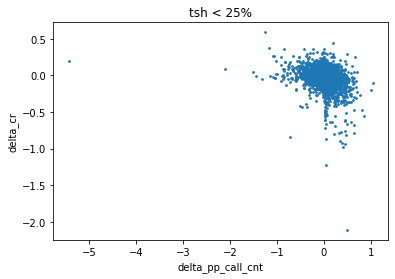

In [69]:
df15 = df14[df14['tsh'] < df14['tsh'].describe()['25%']]
plt.scatter(df15['delta_pp_call_cnt'], df15['delta_cr'], s=3)
plt.xlabel('delta_pp_call_cnt')
plt.ylabel('delta_cr')
plt.title('tsh < 25%')

Text(0.5, 1.0, '25% < tsh < 50%')

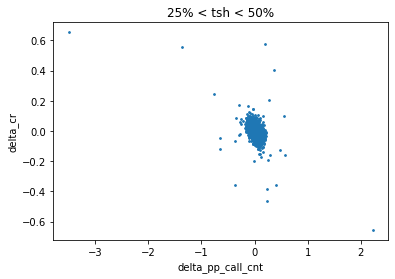

In [70]:
df16 = df14[(df14['tsh'] >= df14['tsh'].describe()['25%']) & (df14['tsh'] < df14['tsh'].describe()['50%'])]
plt.scatter(df16['delta_pp_call_cnt'], df16['delta_cr'], s=3)
plt.xlabel('delta_pp_call_cnt')
plt.ylabel('delta_cr')
plt.title('25% < tsh < 50%')

Text(0.5, 1.0, '50% < tsh < 75%')

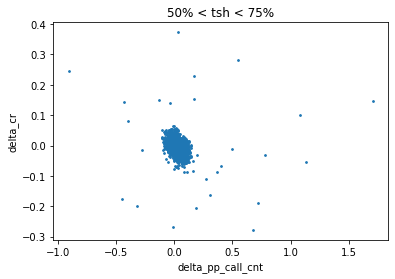

In [71]:
df17 = df14[(df14['tsh'] >= df14['tsh'].describe()['50%']) & (df14['tsh'] < df14['tsh'].describe()['75%'])]
plt.scatter(df17['delta_pp_call_cnt'], df17['delta_cr'], s=3)
plt.xlabel('delta_pp_call_cnt')
plt.ylabel('delta_cr')
plt.title('50% < tsh < 75%')

Text(0.5, 1.0, 'tsh > 75%')

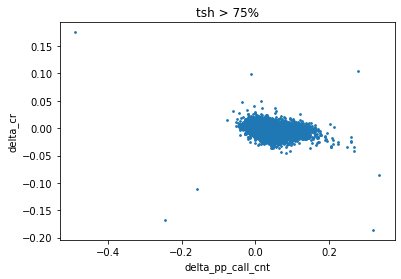

In [72]:
df18 = df14[df14['tsh'] >= df14['tsh'].describe()['75%']]
plt.scatter(df18['delta_pp_call_cnt'], df18['delta_cr'], s=3)
plt.xlabel('delta_pp_call_cnt')
plt.ylabel('delta_cr')
plt.title('tsh > 75%')